# Portfolio TEJ
```Run Environment: conda tej (python 3.8)```
📈
🎄
❄
😢
⛄

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os, copy, json
# model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
# Evaluation
from scipy.stats import shapiro, anderson
import seaborn as sns
# graph
import matplotlib.pyplot as plt
# other
import gc
import pickle
import datetime
import warnings
warnings.filterwarnings('ignore')

## 1. Data

### 1.1 Get from TEJ API 
#### need industry data!
```DO NOT run this cell UNLESS need more data from tej api```

In [26]:
import pandas as pd
import datetime
import os
# set tej_key and base
tej_key = "42ZX84O9jUiap5JOlFABw2XxklwYgY"
api_base = 'https://api.tej.com.tw'

os.environ['TEJAPI_KEY'] = tej_key
os.environ['TEJAPI_BASE']= api_base

import numpy as np
import tejapi
import TejToolAPI 
from zipline.data import bundles


tejapi.ApiConfig.api_key = tej_key  
tejapi.ApiConfig.api_base = api_base

# set date
start='2023-01-01'
end='2023-10-24'

from logbook import Logger, StderrHandler, INFO
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('get_universe')

1.1.1 Tickers
- 以下兩種方式皆能取得曾經上市+上櫃的普通股（不含F股或KY股）：
  - `get_universe(start, end, mkt=['TWSE','OTC'], stktp_c=['普通股'])`
  - `get_universe(start, end, mkt_bd_e=['TSE','OTC','TIB'], mkt=['TWSE','OTC'], stktp_c=['普通股'])`

In [27]:
from zipline.sources.TEJ_Api_Data import get_universe
tickers = get_universe(start, end, mkt=['TWSE','OTC'], stktp_c=['普通股'])
os.environ['mdate'] = '20000103 20231220'

with open("data/tickers.pk", "wb") as f:
    pickle.dump(tickers, f)


[2023-12-20 04:32:45.881587]: INFO: get_universe_TW: Filters：{'mkt': ['TWSE', 'OTC'], 'stktp_c': ['普通股']}


In [30]:
# load
with open("data/tickers.pk", "rb") as f:
    tickles = pickle.load(f)

1.1.2 Define Columns

`# TEJ-Tool-API`\
File in [TEJ github](https://github.com/tejtw/TQuant-Lab) ==> 
[Data Preprocess](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Data%20Preprocess%20-%20tejtoolapi.ipynb)


In [32]:
# 月營收的欄位
columns_rev = ['Industry_Eng', 'Sales_Accu_LastYear', 'Sales_Accu_3M',
       'Sales_Per_Share_Accu_12M', 'YoY_Accu_Sales', 'YoY_Monthly_Sales',
       'Sales_Per_Share_Accu_3M', 'Sales_Accu_3M_LastYear', 'Sales_Monthly',
       'YoY_AccuSales_12M', 'YoY_Accu_Sales_3M', 'MoM_Monthly_Sales',
       'Sales_Accumulated', 'QoQ_Accu_Sales_3M', 'MoM_Accu_Sales_3M',
       'Sales_Monthly_LastYear', 'Outstanding_Shares_1000_Shares']

# 量化籌碼_周 - 集保庫存欄位
columns_chip_week = ['Total_Custodied_Shares_1000_Lots',
       'Custodied_Under_400_Lots_Total_Lots',
       'Custodied_Lots_Between_800_1000_Total_Lots',
       'Custodied_Larger_Than_400_Lots_Pct',
       'Custodied_Lots_Between_400_600_Total_Lots',
       'Custodied_Lots_Between_600_800_Pct', 'Pledged_Stock_Shares_1000_Lots',
       'Custodied_Under_400_Lots_Pct',
       'Custodied_Lots_Between_400_600_Total_Holders',
       'Custodied_Lots_Between_800_1000_Total_Holders',
       'Custodied_Under_400_Lots_Total_Holders',
       'Custodied_Lots_Between_400_600_Pct',
       'Custodied_Lots_Between_800_1000_Pct',
       'Custodied_Greater_Than_1000_Lots_Pct']

# 量化籌碼_日& 交易註記 欄位
columns_chip_day =['Market', 'Dealer_Proprietary_Diff_Vol', 'Margin_Sale',
       'Cash_Redemption', 'Margin_Short_Balance_Amt',
       'Margin_Short_Balance_Vol', 'Dealer_Hedge_Buy_Vol',
       'Day_Trading_Volume_1000_Shares', 'SBL_Short_Returns_Vol',
       'Margin_Maintenance_Ratio', 'Account_Maintenance_Ratio',
       'Margin_Stock_Redemtion', 'Total_Sell_Amt',
       'Margin_Short_Maintenance_Ratio', 'SBL_Short_Balance_Vol',
       'Dealer_Hedge_Buy_Amt', 'Total_Buy_Amt', 'Total_Diff_Amt',
       'Fund_Diff_Vol', 'Dealer_Proprietary_Buy_Vol',
       'Dealer_Proprietary_Sell_Amt', 'Margin_Day_Trading_Amt',
       'Total_Diff_Vol', 'SBL_Short_Sales_Vol', 'SBL_Short_Balance_Amt',
       'Dealer_Stock_Holding_Pct', 'Dealer_Hedge_Sell_Vol', 'Qfii_Buy_Vol',
       'Qfii_Stock_Holding_Pct', 'Qfii_Sell_Vol', 'Fund_Stock_Holding_Pct',
       'Dealer_Proprietary_Buy_Amt', 'Dealer_Hedge_Diff_Amt', 'Qfii_Sell_Amt',
       'Margin_Day_Trading_Vol', 'Fund_Sell_Amt', 'Day_Trading_Pct',
       'Margin_Short_Sales', 'Fund_Diff_Amt', 'Margin_Balance_Ratio',
       'SBL_Short_Sales_Amt', 'Fund_Buy_Vol', 'Qfii_Buy_Amt',
       'Margin_Balance_Vol', 'Qfii_Diff_Vol', 'Margin_Purchase',
       'Dealer_Hedge_Sell_Amt', 'Dealer_Proprietary_Sell_Vol', 'Fund_Sell_Vol',
       'Margin_Quota', 'Qfii_Diff_Amt', 'Total_Sell_Vol', 'Margin_Short_Quota',
       'Margin_Short_Coverting', 'Fund_Buy_Amt', 'Dealer_Proprietary_Diff_Amt',
       'Total_Buy_Vol', 'Margin_Balance_Amt', 'SBL_Short_Quota',
       'Dealer_Hedge_Diff_Vol', 'Component_Stock_of_TPEx200_Fg', 'Industry',
       'Component_Stock_of_MSCI_TW_Fg', 'Component_Stock_of_High_Dividend_Fg',
       'Security_Type_Chinese', 'Suspension_of_Buy_After_Day_Trading_Fg',
       'Matching_Period', 'Component_Stock_of_TWN50_Fg',
       'Component_Stock_of_MidCap100_Fg', 'Suspended_Trading_Stock_Fg',
       'Market_Board', 'Full_Delivery_Stock_Fg', 'Disposition_Stock_Fg',
       'Security_Type_English', 'Attention_Stock_Fg', 'Industry_Eng',
       'Component_Stock_of_TPEx50_Fg', 'Limit_Up_or_Down_in_Opening_Fg',
       'Limit_Up_or_Down']

# 價量與籌碼
# Adj prc = Close (Open) * Adjust Factor
columns_prc_chips = ['Open','High','Low','Close','Adjust_Factor','Volume_1000_Shares','Value_Dollars'
           'Transaction','Last_Bid','Last_Offer','Average_Trade_Price','ROI','High_Low_Diff','Turnover'
           'Issue_Shares_1000_Shares','Market_Cap_Dollars','Market_Cap_Percentage','Trade_Value_Percentage'
           'PER_TWSE','PBR_TWSE','Dividend_Yield_TWSE','Cash_Dividend_Yield_TEJ',
           'Qfii_Buy_Vol','Qfii_Sell_Vol','Qfii_Diff_Vol','Qfii_Buy_Amt','Qfii_Sell_Amt','Qfii_Diff_Amt','Qfii_Stock_Holding_Pct','Fund_Buy_Vol',
           'Fund_Sell_Vol','Fund_Diff_Vol','Fund_Buy_Amt','Fund_Sell_Amt','Fund_Diff_Amt','Fund_Stock_Holding_Pct','Dealer_Proprietary_Buy_Vol','Dealer_Proprietary_Sell_Vol','Dealer_Proprietary_Diff_Vol','Dealer_Proprietary_Buy_Amt',
           'Dealer_Proprietary_Sell_Amt','Dealer_Proprietary_Diff_Amt','Dealer_Hedge_Buy_Vol','Dealer_Hedge_Sell_Vol','Dealer_Hedge_Diff_Vol','Dealer_Hedge_Buy_Amt','Dealer_Hedge_Sell_Amt','Dealer_Hedge_Diff_Amt',
           'Dealer_Stock_Holding_Pct','Total_Buy_Vol','Total_Sell_Vol','Total_Diff_Vol','Total_Buy_Amt','Total_Sell_Amt','Total_Diff_Amt'
            ]

# 財務類別
fin_type = ['A','Q','TTM']

# 財務資料 - 財務僅會計師核閱
columns_comp_finance =['Total_Operating_Cost','Sales_Per_Share','Return_Rate_on_Equity_A_percent',
       'Proceeds_from_Disposal_of_Fixed_and_Intangible_Assets',
       'Cash_Flow_from_Operating_Activities', 
       'Other_Adjustment_from_Operating_Activities', 'Borrowings',       
       'Total_Operating_Expenses', 'Gross_Margin_Rate_percent',
       'Sales_Growth_Rate', 'Net_Income_Per_Share','Total_Assets',
       'Short_Term_Borrowings_Financial_Institutions',
       'Pre_Tax_Income_Growth_Rate', 'Total_Equity_Growth_Rate',
       'Total_Operating_Income','Total_Assets_Turnover',
       'Operating_Income_Per_Share','Pre_Tax_Income_Rate_percent', 
       'Gross_Profit_Loss_from_Operations','Return_on_Total_Assets',
       'Depreciation_and_Amortisation','Total_Interest_Income',
       'Fixed_Asset_Turnover', 'Decrease_Increase_in_Prepayments']

# 財務資料 - 財務包含公司自結數與會計師核閱
columns_comp_finance_2 =['Total_Operating_Cost','Sales_Per_Share','Return_Rate_on_Equity_A_percent',
       'Proceeds_from_Disposal_of_Fixed_and_Intangible_Assets',
       'Cash_Flow_from_Operating_Activities', 
       'Other_Adjustment_from_Operating_Activities', 'Borrowings',       
       'Total_Operating_Expenses', 'Gross_Margin_Rate_percent',
       'Sales_Growth_Rate', 'Net_Income_Per_Share','Total_Assets',
       'Short_Term_Borrowings_Financial_Institutions',
       'Pre_Tax_Income_Growth_Rate', 'Total_Equity_Growth_Rate',
       'Total_Operating_Income','Total_Assets_Turnover',
       'Operating_Income_Per_Share','Pre_Tax_Income_Rate_percent', 
       'Gross_Profit_Loss_from_Operations','Return_on_Total_Assets',
       'Depreciation_and_Amortisation','Total_Interest_Income',
       'Fixed_Asset_Turnover', 'Decrease_Increase_in_Prepayments',]


In [33]:
# define columns
columns = columns_rev + columns_prc_chips + columns_comp_finance

# check if duplicated in columns
if [item for item in columns if columns.count(item) > 1] != []:
    print("duplicated columns!")
    columns = set(columns)

# len columns
len(columns)

94

In [ ]:
# get data from tej api
ticker = tickers
data = TejToolAPI.get_history_data(ticker=ticker, 
                                   columns=columns,
                                   transfer_to_chinese=False,
                                   fin_type=fin_type,
                                   include_self_acc='N' 
                                  )
data 

In [ ]:
"""
columns = ['Industry_Eng']
ticker = tickers
data_i = TejToolAPI.get_history_data(ticker=ticker, 
                                   columns=columns,
                                   transfer_to_chinese=False,
                                   fin_type=fin_type,
                                   include_self_acc='N' 
                                  )
data_i 
"""

`# revenue strategy`

In [ ]:
# revenue strategy
columns = ['Industry_Eng','開盤價','收盤價', 'roi', 'YoY_Monthly_Sales', 'eps', '外資買賣超金額_元','營業毛利率', '營業利益率', '稅後淨利率', '業外收支率', '營收成長率', '營業毛利成長率', '營業利益成長率', '稅後淨利成長率', '淨值成長率','Inventories', 'mktcap']
data = TejToolAPI.get_history_data(ticker=tickers, columns=columns, transfer_to_chinese=False, start = '2013-01-01', end = '2023-07-24')
data = data.sort_values(['coid','mdate'])

Store data

In [ ]:
# store data
import pickle
with open("data/cross_section_stock.pk", "wb") as f:
    pickle.dump(data, f)

# store data in database
# Store in pc and database
import sqlalchemy
import pickle
from sqlalchemy import create_engine, VARCHAR
host = 'localhost'
port = "3306"
user = 'root'
pwd = 'test123'
database_name = 'tej'
con = create_engine('mysql+pymysql://'+user+':'+pwd+'@'+host+':'+port+'/'+database_name)

with open("C:/Users/USER/Desktop/TEJ/data/revenue_strategy.pickle", "wb") as f:
    pickle.dump(data, f)

table_name = "cross_section_stock"
data.to_sql(table_name, con=con, if_exists='replace')

### 1.2 Load Data Stored in PC 

1.2.1 pickle

In [52]:
with open(f"data/cross_section_stock.pk", "rb") as f:
    data_cross_section = pickle.load(f)
# use csv
# data_bundled = pd.read_csv('data/revenue_bundled.csv')
with open(f"data/revenue_strategy.pk", "rb") as f:
    data_revenue = pickle.load(f)

1.2.2 Database

In [49]:
# Store in pc and database
import sqlalchemy
import pickle
from sqlalchemy import create_engine, VARCHAR
host = 'localhost'
port = "3306"
user = 'root'
pwd = 'test123'
database_name = 'tej'
con = create_engine('mysql+pymysql://'+user+':'+pwd+'@'+host+':'+port+'/'+database_name)
table_name = "revenue_strategy"

sql_query = f'SELECT * FROM {table_name}'
data_revenue = pd.read_sql(sql_query, con)
data_revenue.drop(columns=["index"], inplace = True)

In [50]:
import pickle
with open("data/revebue_strategy.pk", "wb") as f:
    pickle.dump(data_revenue, f)

### 1.3 Preprocess and Clean Data

1. Price to adjusted price. Close
2. Compute Weekly Return 
3. Weekdays: ```{"0": Monday, "1": ~, ...}```

In [9]:
data["Adj Close"] = data["Close"] * data["Adjust_Factor"]
data.shape

(1188640, 131)

In [17]:
# Compute return
# for weekdays:
# 0 -> Monday, ...
def data_to_week(data): # daily data
    prc_return = "Adj Close"
    data_week = data[data["mdate"].dt.weekday == 4]
    data_week_return = pd.DataFrame()
    for k, symbol in enumerate(data["coid"].unique()):
        print(f"{k} symbol: {symbol}")
        data_coid = data_week[data_week["coid"] == symbol].copy()
        data_coid["return"] = (data_coid["Close"].shift(-1) - data_coid["Close"])/data_coid["Close"]
        data_week_return = pd.concat([data_week_return, data_coid], axis = 0)
        
    return data_week_return
    
data_week_return = data_to_week(data)
data_backup = data_week_return.copy()

0 symbol: 1101
1 symbol: 1102
2 symbol: 1103
3 symbol: 1104
4 symbol: 1108
5 symbol: 1109
6 symbol: 1110
7 symbol: 1201
8 symbol: 1203
9 symbol: 1210
10 symbol: 1213
11 symbol: 1215
12 symbol: 1216
13 symbol: 1217
14 symbol: 1218
15 symbol: 1219
16 symbol: 1220
17 symbol: 1225
18 symbol: 1227
19 symbol: 1229
20 symbol: 1231
21 symbol: 1232
22 symbol: 1233
23 symbol: 1234
24 symbol: 1235
25 symbol: 1236
26 symbol: 1240
27 symbol: 1259
28 symbol: 1264
29 symbol: 1268
30 symbol: 1301
31 symbol: 1303
32 symbol: 1304
33 symbol: 1305
34 symbol: 1307
35 symbol: 1308
36 symbol: 1309
37 symbol: 1310
38 symbol: 1312
39 symbol: 1313
40 symbol: 1314
41 symbol: 1315
42 symbol: 1316
43 symbol: 1319
44 symbol: 1321
45 symbol: 1323
46 symbol: 1324
47 symbol: 1325
48 symbol: 1326
49 symbol: 1336
50 symbol: 1339
51 symbol: 1342
52 symbol: 1402
53 symbol: 1409
54 symbol: 1410
55 symbol: 1413
56 symbol: 1414
57 symbol: 1416
58 symbol: 1417
59 symbol: 1418
60 symbol: 1419
61 symbol: 1423
62 symbol: 1432
63

## 2. Factors Research
使用 alphalens 進行因子分析
- Returns（報酬率分析）
- Information（資訊分析）
- Autocorrelation（自相關分析）

In [35]:
data.mdate = pd.to_datetime(data.mdate, utc =True)
predictive_factor = data[['mdate','coid','YoY_Monthly_Sales']].set_index(['mdate','coid']).unstack('coid')
predictive_factor = predictive_factor.stack()
pricing = data[['mdate','coid','Open']].set_index(['mdate','coid']).iloc[1:].\
                                              unstack('coid')['Open']
pricing = pricing.shift(-1)
pricing.head(3)

coid,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
mdate,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,43.25,42.95,19.20,23.55,12.60,19.85,18.1,22.35,37.15,51.00,...,22.55,40.7,16.15,12.05,9.85,95.0,21.05,110.0,34.30,10.20
2021-01-05 00:00:00+00:00,43.10,42.95,19.10,23.30,12.30,19.85,17.9,21.90,36.65,50.50,...,22.60,40.9,16.15,11.95,9.91,95.7,21.10,111.0,33.60,10.20
2021-01-06 00:00:00+00:00,42.95,43.30,18.75,22.80,12.05,19.70,18.0,21.30,36.00,49.75,...,22.65,40.4,16.00,11.95,9.97,94.8,20.45,107.0,31.65,10.35


### 2.2 Linear Regression for Original Data

##### 2.2.1 Split into dependent variables (y) and independent variables (X)
1. Check `columns type != float`
2. Split data

In [43]:
# Check `columns type != float`
for i in data.columns:
    if data[i].dtypes != np.float64:
        print(i)

coid
mdate


In [44]:
# Split data
# "Industry_Eng"
data_week_return = data_backup.copy()
data_week_return.dropna(inplace=True)
data_week_return = data_week_return.set_index(["coid", "mdate"])
X = data_week_return.drop(["return"], axis = 1)
y = data_week_return["return"]


##### 2.2.2 Fit regression

In [45]:
# Compute the epsilons
linear_reg_ = sm.OLS(y, sm.add_constant(X))
linear_reg = linear_reg_.fit()

linear_reg.summary()
r2_ignore_industry = linear_reg.rsquared
linear_reg.rsquared

0.006273506563992615

### 2.3 Industry: Encoding
⛄ 1. Ignore industry \
⛄ 2. One hot encoding \
⛄ 3. Train one-by-one with group data by industry \
📈 Best Result: 3

One hot encoding

In [146]:
data_week_return = data_backup.copy()
one_hot_encoded = pd.get_dummies(data_week_return['Industry_Eng'], prefix='Category')
data_week_return = pd.concat([data_week_return, one_hot_encoded], axis=1)
data_week_return.dropna(inplace=True)
data_week_return = data_week_return.set_index(["coid", "mdate"])
X = data_week_return.drop(["return", "Industry_Eng"], axis = 1)
y = data_week_return["return"]

In [112]:
# Compute the epsilons
linear_reg_ = sm.OLS(y, sm.add_constant(X))
linear_reg = linear_reg_.fit()

linear_reg.summary()
r2_onehotencoding = linear_reg.rsquared

Predict with group data by industry

In [115]:
data_week_return = data_backup.copy()
data_week_return.dropna(inplace=True)
data_week_return = data_week_return.set_index(["coid", "mdate"])
r_2 = []
for industry in data_week_return["Industry_Eng"].unique():
    data_1_industry = data_week_return[data_week_return["Industry_Eng"] == industry]
    X = data_1_industry.drop(["return", "Industry_Eng"], axis = 1)
    y = data_1_industry["return"]

    # Compute the epsilons
    # eps: epsilons
    # EPS: Earnings per Share
    linear_reg_ = sm.OLS(y, sm.add_constant(X))
    linear_reg = linear_reg_.fit()
    predict = linear_reg.predict(sm.add_constant(X))
    eps = y - predict
    eps = pd.DataFrame(eps, columns = ["eps"])
    predict = pd.DataFrame(predict, columns=["prediction"])
    X_eps = pd.merge(eps, X, left_index=True, right_index=True)
    X_eps = pd.merge(predict, X_eps, left_index=True, right_index=True)
    
    linear_reg.summary()
    if X.shape[0] > X.shape[1]:
        r_2.append(linear_reg.rsquared)


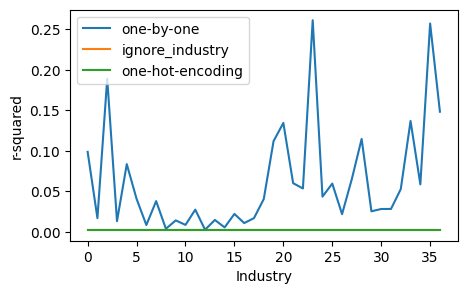

(0.001978855240732158, 0.0026413265567976074, 0.06264375794592474)

In [116]:

min(r_2)
max(r_2)
plt.figure(figsize=(5, 3))
plt.plot(r_2, label = "one-by-one")
plt.plot([r2_ignore_industry]*len(r_2), label = "ignore_industry")
plt.plot([r2_onehotencoding]*len(r_2), label = "one-hot-encoding")
plt.xlabel("Industry")
plt.ylabel("r-squared")
plt.legend()
plt.show()
r2_ignore_industry, r2_onehotencoding, np.mean(r_2)

### 2.4 Add more variables
- Indicators
- Quantities (價量資料)
- Finance ratios

#### 2.4.1 KD

KD指標是技術分析常見的指標之一，主要用於判斷股價當前的強弱程度與可能反轉的時機。KD指標的數值介於0-100，一般以50作為分水嶺，當指標大於50時，表示股價處於強勢階段；反之，當股價小於50時，股價屬於弱勢階段。另外，當KD指標小於20時，股票往往有超賣的跡象，隨時有反轉向上的可能；反之當KD指標大於80時，股票往往有超買的跡象，隨時有反轉向下的可能。因此，許多人依此來建構交易訊號，作為買賣股票的依據。

KD指標的計算流程:

- RSV = ((當日收盤價-近N日的最低價)/(近N日的最高價-近N日的最低價))*100
- K值 = 昨日K值 × (2/3) + 當日RSV × (1/3)
- D值 = 昨日D值 × (2/3) + 當日K值 × (1/3)

從算式來看，可以把RSV解讀成當日股價相較於近N日 (本文N = 9)股價，是屬於較強勢還是弱勢。K值，又被稱為快線，因為受到當日股價強弱的影響較大；而D值計算的原理如同再進行一次平滑，故對當前股價變化反應較慢。

本文採用KD指標來判斷股價反轉時機，利用以下進出場規則建立交易策略並進行回測:
- K ≤ 20，買入，因其代表股價處於較弱、市場過冷
- K ≥ 80，賣出，代表市場過熱，因此選擇獲利了結

In [162]:
# use day data
# ROI: return
data.head()

,coid,mdate,Industry_Eng,ROI,Close,Market_Cap_Dollars,Open,Qfii_Diff_Amt,YoY_Monthly_Sales,Net_Income_Rate_percent_A,...,Operating_Income_Growth_Rate_TTM,Inventories_A,Inventories_Q,Inventories_TTM,Net_Non_operating_Income_Ratio_A,Net_Non_operating_Income_Ratio_Q,Net_Non_operating_Income_Ratio_TTM,Total_Equity_Growth_Rate_A,Total_Equity_Growth_Rate_Q,Total_Equity_Growth_Rate_TTM
0,1101,2021-01-04,M1100 Cement,0.0000,43.20,2.510030e+11,43.20,114998.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1101,2021-01-05,M1100 Cement,-0.2315,43.10,2.504220e+11,43.25,-63055.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1101,2021-01-06,M1100 Cement,-0.3480,42.95,2.495504e+11,43.10,-53387.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1101,2021-01-07,M1100 Cement,-0.2328,42.85,2.489694e+11,42.95,-205252.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1101,2021-01-08,M1100 Cement,0.2334,42.95,2.495504e+11,42.90,178200.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import yfinance as yf
for coid in data.coid.unique():
    data_coid = data[data.coid == coid]
    max_date, min_date = data_coid.mdate.max(), data_coid.mdate.min()
    prc = yf.download(coid + ".TW", start=min_date, end=max_date)  
    prc = prc.reset_index().rename(columns={"Date": "mdate"})
    break

In [184]:
prc.reset_index().Date
data.mdate[5] in list(prc.reset_index().Date)
pd.merge(data_coid, prc.rename(columns={"Date": "mdate"}), on=)

True

In [ ]:
import talib
import numpy as np
import pandas as pd

# Calculate KDJ
kdj = talib.STOCH(df['High'].values,
                  df['Low'].values,
                  df['Close'].values,
                  fastk_period=9,
                  slowk_period=3,
                  slowd_period=3)

# Create a DataFrame with the KDJ values
kdj_df = pd.DataFrame({'%K': kdj[0], '%D': kdj[1]})

# Print the DataFrame with KDJ values
print(kdj_df)

#### 2.4.2 Finance Ratio

In [196]:
data.columns

Index(['coid', 'mdate', 'Industry_Eng', 'ROI', 'Close', 'Market_Cap_Dollars',
       'Open', 'Qfii_Diff_Amt', 'YoY_Monthly_Sales',
       'Net_Income_Rate_percent_A', 'Net_Income_Rate_percent_Q',
       'Net_Income_Rate_percent_TTM', 'Gross_Margin_Rate_percent_A',
       'Gross_Margin_Rate_percent_Q', 'Gross_Margin_Rate_percent_TTM',
       'Net_Income_Growth_Rate_A', 'Net_Income_Growth_Rate_Q',
       'Net_Income_Growth_Rate_TTM', 'Gross_Margin_Growth_Rate_A',
       'Gross_Margin_Growth_Rate_Q', 'Gross_Margin_Growth_Rate_TTM',
       'Basic_Earnings_Per_Share_A', 'Basic_Earnings_Per_Share_Q',
       'Basic_Earnings_Per_Share_TTM', 'Operating_Income_Rate_percent_A',
       'Operating_Income_Rate_percent_Q', 'Operating_Income_Rate_percent_TTM',
       'Sales_Growth_Rate_A', 'Sales_Growth_Rate_Q', 'Sales_Growth_Rate_TTM',
       'Operating_Income_Growth_Rate_A', 'Operating_Income_Growth_Rate_Q',
       'Operating_Income_Growth_Rate_TTM', 'Inventories_A', 'Inventories_Q',
       'Invento

### 2.5 Polynomial / kernel
- ⛄Polynomial degree = 2
    - ⛄centered by day and industry
- ⛄Kernel

In [ ]:
data_week_return = data_backup.copy()
data_week_return.dropna(inplace=True)
data_week_return = data_week_return.set_index(["coid", "mdate"])
r_2 = []
for industry in data_week_return["Industry_Eng"].unique():
    print(f"Start {industry}")
    data_1_industry = data_week_return[data_week_return["Industry_Eng"] == industry]
    X = data_1_industry.drop(["return", "Industry_Eng"], axis = 1)
    y = data_1_industry["return"]

    # create polynomial variables and center variables
    X.reset_index(inplace=True)
    X_center = pd.DataFrame()

    # center by each date
    for date in X["mdate"].unique():
        X_date = X[X["mdate"] == date]
        
        # center columns by columns and create polynomial variables
        for col in X_date.drop(["mdate", "coid"], axis = 1).columns:
            X_date[col] = X_date[col] - X_date[col].mean()
            X_date[f"{col}**2"] = X_date[col] ** 2
        X_center = pd.concat([X_center, X_date], axis = 0)
    X = X_center.set_index(["coid", "mdate"]).reindex(y.index)

    # fit
    linear_reg_ = sm.OLS(y, sm.add_constant(X))
    linear_reg = linear_reg_.fit()
    
    linear_reg.summary()
    if X.shape[0] > X.shape[1]:
        r_2.append(linear_reg.rsquared)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(r_2, label = "one-by-one")
plt.plot([r2_ignore_industry]*len(r_2), label = "ignore_industry")
plt.plot([r2_onehotencoding]*len(r_2), label = "one-hot-encoding")
plt.xlabel("Industry")
plt.ylabel("r-squared")
plt.legend()
plt.show()
np.mean(r_2)

### 2.6 Lag Operators: Autocorrelation

### 2.7 Splines
[Cubic-Splines](https://colab.research.google.com/github/tgteacher/numerical-methods/blob/master/notebooks/Chapter3.ipynb#scrollTo=SLLvPEzPnYCr): poly interpolation, cubic interpolation, and Newton interpolation

In [274]:
from scipy.interpolate import CubicSpline

In [ ]:
data_week_return = data_backup.copy()
data_week_return.dropna(inplace=True)
data_week_return = data_week_return.set_index(["coid", "mdate"])
r_2 = []
for industry in data_week_return["Industry_Eng"].unique():
    print(f"Start {industry}")
    data_1_industry = data_week_return[data_week_return["Industry_Eng"] == industry]
    X = data_1_industry.drop(["return", "Industry_Eng"], axis = 1)
    y = data_1_industry["return"]
    cs = CubicSpline(X, y)

    linear_reg_ = sm.OLS(y, sm.add_constant(X))
    linear_reg = linear_reg_.fit()
    
    linear_reg.summary()
    if X.shape[0] > X.shape[1]:
        r_2.append(linear_reg.rsquared)

## 3. Check the Assumption/Suitability of Lienar Model

### 3.1 Split data to X and y

In [ ]:
data_month = data[data["mdate"].dt.day == 1]
data_month_return = pd.DataFrame()
for k, symbol in enumerate(data["coid"].unique()):
    print(f"{k} symbol: {symbol}")
    data_coid = data_month[data_month["coid"] == symbol].copy()
    data_coid["return"] = (data_coid["Open"].shift(-1) - data_coid["Open"])/data_coid["Open"]
    data_month_return = pd.concat([data_month_return, data_coid], axis = 0)
data_month_return
data_backup = data_month_return.copy()

In [92]:
data_month_return = data_backup.copy()
data_month_return.dropna(inplace=True)
data_month_return = data_month_return.set_index(["coid", "mdate"])
X = data_month_return.drop(["return", "Industry_Eng"], axis = 1)
y = data_month_return["return"]

### 3.2 Assumptions for Simple Linear Regression
- How to check Epsilon: i.i.d normal ?

##### 殘差診斷

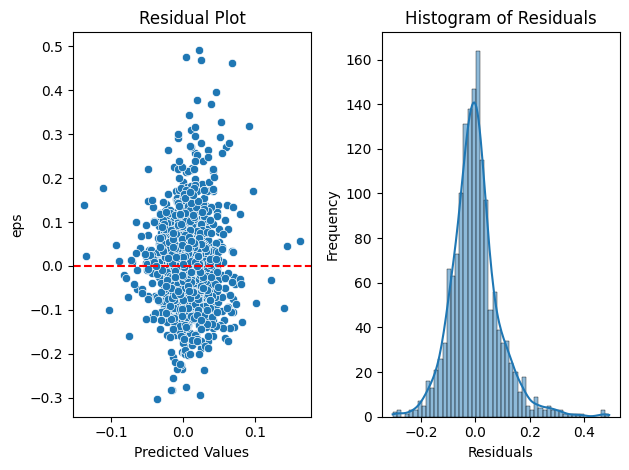

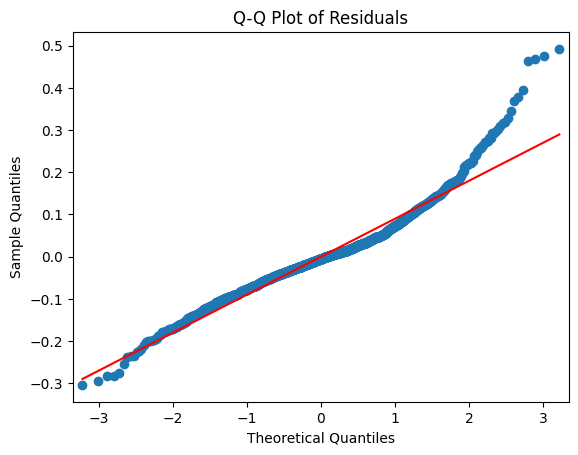

In [81]:
plt.subplot(1, 2, 1)
# Residual plot
sns.scatterplot(x=X_eps["prediction"], y=X_eps["eps"])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')

# histogram
plt.subplot(1, 2, 2)
sns.histplot(X_eps["eps"], kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Q-Q
sm.qqplot(X_eps["eps"], line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [ ]:
# from chatgpt, have no idea
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.influence_plot(linear_reg, ax=ax, criterion="cooks")
plt.title("Leverage and Cook's Distance")
plt.show()

### 3.3 Correlation of Variables

## 4. Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize


# fill missing value
data_preprocess = pd.DataFrame()
for k, symbol in enumerate(data["coid"].unique()):
    print(f"{k} symbol: {symbol}")
    data_coid = data[data["coid"] == symbol].copy()
    data_coid.fillna("ffill")
    data_preprocess = pd.concat([data_preprocess, data_coid], axis = 0)
data_preprocess.dropna(inplace=True)

# standardise
data_scaler_winsorise = pd.DataFrame()
for k, date in enumerate(data_preprocess["mdate"].unique()):
    print(f"date: {date}")
    data_period = data_preprocess[data_preprocess["mdate"] == date].copy()
    data_period.set_index(["coid", "mdate", "Industry_Eng", "Close", "Open"], inplace=True)
    index = data_period.index

    # standardise                     
    scaler = StandardScaler()
    data_period = pd.DataFrame(scaler.fit_transform(data_period), columns=data_period.columns).\
                                set_index(index)
    
    # winsorise
    for col in data_period.columns:
        data_period[col] = winsorize(data_period[col], limits=[0.001, 0.001], inplace=False)
        
    data_scaler_winsorise = pd.concat([data_scaler_winsorise, data_period], axis = 0)
    
data_preprocess = data_scaler_winsorise
data_preprocess = data_preprocess.reset_index()

data_backup = data_preprocess.copy()

## 5. Rolling Prediction

Functions

In [155]:
def update_data(data_week_return, start_train_date, train_size = 6):
    start_train_date = start_train_date + pd.DateOffset(weeks = 1)
    end_train_date = start_train_date + pd.DateOffset(weeks = train_size)
    start_test_date = end_train_date + pd.DateOffset(weeks = 1)
    end_test_date = start_test_date + pd.DateOffset(weeks = 1)
    train = data_week_return[(data_week_return["mdate"] < end_train_date) & \
                            (data_week_return["mdate"] >= start_train_date)]
    test = data_week_return[(data_week_return["mdate"] < end_test_date) & \
                            (data_week_return["mdate"] >= start_test_date)]
    train.set_index(["coid", "mdate"], inplace=True)
    test.set_index(["coid", "mdate"], inplace=True)
    return train, test, start_train_date, start_test_date

def prediction_period(train, test, degree = 3, kernel = False):
    predict_result_market = pd.DataFrame()
    for industry in train["Industry_Eng"].unique():
        train_1_industry = train[train["Industry_Eng"] == industry]
        test_1_industry = test[test["Industry_Eng"] == industry]
        train_X = train_1_industry.drop(["return", "Industry_Eng"], axis = 1)
        train_y = train_1_industry["return"]
        test_X = test_1_industry.drop(["return", "Industry_Eng"], axis = 1)
        test_y = test_1_industry["return"]
        # print(f"predicting {industry} ... with test {len(test_y)} samples")

        if degree == None:
            if sm.add_constant(test_X).shape[1] != sm.add_constant(train_X).shape[1]:
                test_X["const"] = 1.
            linear_reg_ = sm.OLS(train_y, sm.add_constant(train_X))
            linear_reg = linear_reg_.fit()
            predict = linear_reg.predict(sm.add_constant(test_X))
        elif kernel == True:
            pass
        else:
            linear_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
            linear_reg.fit(train_X, train_y)
            predict = linear_reg.predict(test_X)            
        
        predict_ret = pd.DataFrame(predict, columns = ["predicted_ret"]).set_index(test_y.index)
        predict_ret = pd.merge(test_y, predict_ret, left_index=True, right_index=True)
        predict_result_market = pd.concat([predict_result_market, predict_ret], axis = 0)
    return predict_result_market

def backtest(predict_result_market, long_ratio): 
    date = predict_result_market.reset_index()["mdate"].unique()[0]

    # Decide when to trade
    """
    long = np.percentile(predict_result_market["predicted_ret"], 80)
    short = np.percentile(predict_result_market["predicted_ret"], 20)
    """

    # Got stock to be traded
    """
    long_stock = predict_result_market[predict_result_market["predicted_ret"] >= long]
    short_stock = predict_result_market[predict_result_market["predicted_ret"] <= short]
    """
    long_stock = predict_result_market.sort_values('predicted_ret', ascending=False)\
        .head(10)
    short_stock = predict_result_market.sort_values('predicted_ret', ascending=True)\
        .head(10)

    # Decide weights
    long_stock["predicted_ret"] = long_stock["predicted_ret"] + abs(min(long_stock["predicted_ret"]))
    long_stock["weight"] = long_stock["predicted_ret"]/sum(long_stock["predicted_ret"]) * long_ratio
    short_stock["predicted_ret"] = short_stock["predicted_ret"] - abs(max(short_stock["predicted_ret"]))
    short_stock["weight"] = short_stock["predicted_ret"]/sum(short_stock["predicted_ret"]) * (1-long_ratio)
    total_weights = sum(long_stock["weight"]) + sum(short_stock["weight"])

    # Portfolio return
    returns = sum(long_stock["return"] * long_stock["weight"]) - sum(short_stock["return"] * short_stock["weight"])
    backtest_ret = pd.DataFrame([[date, returns]], columns=["date", "returns"])

    # Print results
    print(f"Check Sum Weights: {total_weights}")
    print(f"Backtest Returns: {returns}")
    print(f"Long Stock: {len(long_stock.reset_index()['coid'])}, \
          {long_stock.reset_index()['coid'].values}")
    print(f"Short Stock: {len(short_stock.reset_index()['coid'])}, \
          {short_stock.reset_index()['coid'].values}")
    
    return backtest_ret

Rolling Prediction

In [ ]:
################################################################
# Data Initialisation
data_week_return = data_backup.copy()
data_week_return.dropna(inplace=True)
max_date = max(data_week_return["mdate"])

# Train test period
train_size = 52 # weeks
start_train_date = min(data_week_return["mdate"])
end_train_date = start_train_date + pd.DateOffset(weeks = train_size)
start_test_date = end_train_date + pd.DateOffset(weeks = 1)
end_test_date = start_test_date + pd.DateOffset(weeks = 1)

# Train test data
train = data_week_return[(data_week_return["mdate"] < end_train_date) & \
                          (data_week_return["mdate"] >= start_train_date)]
test = data_week_return[(data_week_return["mdate"] < end_test_date) & \
                          (data_week_return["mdate"] >= start_test_date)]
train.set_index(["coid", "mdate"], inplace=True)
test.set_index(["coid", "mdate"], inplace=True)

# Polynomial degree
degree = None

################################################################
# Initialise of asset
cum_asset = 1
market_hold = 1
cum_asset_period = pd.DataFrame()

# Rolling Prediction
while True:
    print("="*80)
    print(f"Test: {start_test_date} with size {test.shape}")

    if test.shape[0] != 0:
        # train
        predict_result_market = prediction_period(train, test, degree=degree)
        # backtest
        backtest_ret = backtest(predict_result_market, long_ratio=0.5)    
        # cumulative return
        cum_asset *= (1 + backtest_ret["returns"].values[0] - 0.004)
        market_hold *= (1+ test["return"].mean())
    else:
        pass
    cum_asset_df = pd.DataFrame([[start_test_date, cum_asset, market_hold]], 
                                columns=["date", "cum_asset", "market"])
    cum_asset_period = pd.concat([cum_asset_period, cum_asset_df], axis = 0)
    
    # update
    train, test, start_train_date, start_test_date = update_data(data_week_return, start_train_date, train_size)
    if start_test_date > max_date:
        break
    

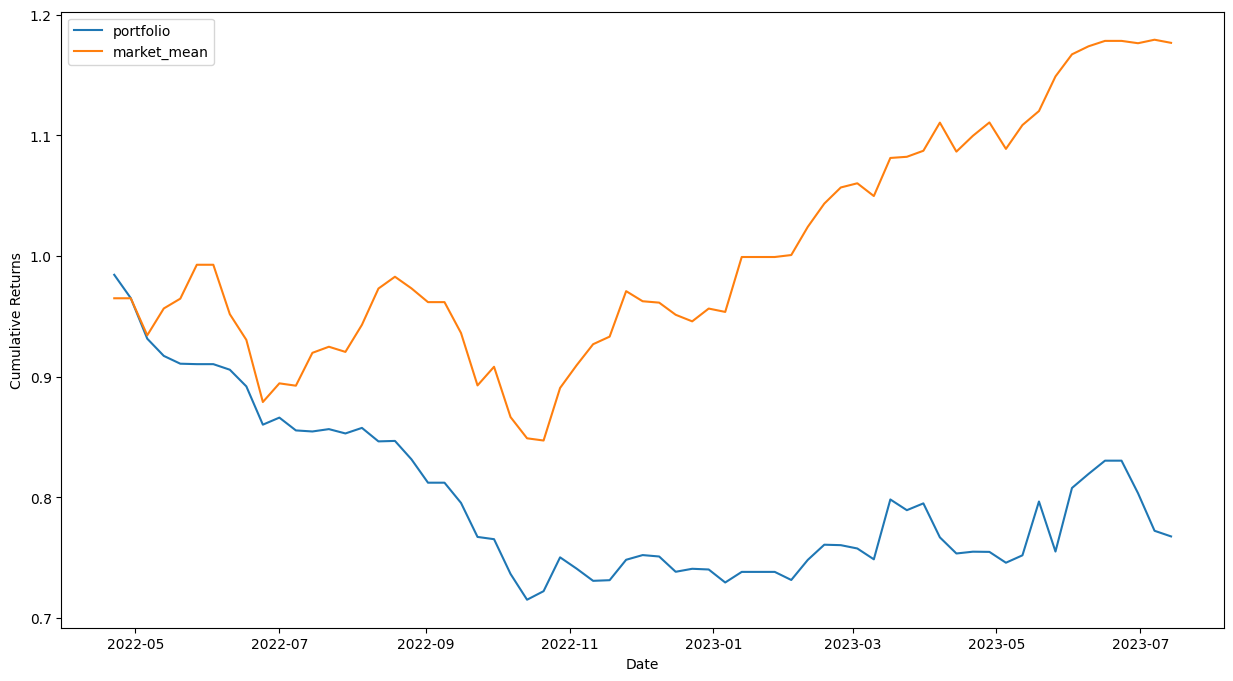

In [158]:
cum_asset_period.set_index(["date"], inplace=True)
plt.figure(figsize=(15, 8))
plt.plot(cum_asset_period["cum_asset"], label = "portfolio")
plt.plot(cum_asset_period["market"], label = "market_mean")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

Backtest

In [333]:
backtest_ret

,date,returns
0,2023-02-01 00:00:00+00:00,0.030738


## 6. Time Series

In [2]:
def params_setting(model):
    if model == "time series":
        params = {
            # "normalize": True        
        }
    return params

In [3]:
# =============================================================================================================
# settings
models = {1: "time series"}
model = models[1]
param = params_setting(model)
model_strategy = {
    "model": model,     # "linear" or "decision tree" or "xgboost" or "svm" or "neural network"
    "long": 90,         # percentile
    "short": 10,        # percentile
    "train_size": 3,    # y
    "test_size": 1,     # m
    "test_year": 2021,  # start test from 2021/01
    }

train_size = model_strategy["train_size"]
test_size = model_strategy["test_size"]
future_predicting = False # actually predicting future
# ==============================================================================================================
t = summary()

## Time Series
https://medium.com/tej-api-%E9%87%91%E8%9E%8D%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90/%E8%B3%87%E6%96%99%E7%A7%91%E5%AD%B8-%E5%8D%81-arima-garch%E6%A8%A1%E5%9E%8B-%E4%B8%8A-4cf07dac75fd

In [4]:
# data
    # if pca add index. if no pca reset index. , "open", "close", "high", "low", "Volume"
with open(f"data/{industry}/data4model.pickle", "rb") as f:
    data = pickle.load(f)
data = data.reset_index()
data["ymd"] = pd.to_datetime(data["ymd"], format="%Y-%m-%d")
data = data.set_index(["code", "ymd"])

In [62]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import pmdarima as pmd

def check_stationality(data):
    s, n, e = 0, 0, 0
    y_train = data.reset_index()
    for i in y_train["code"].unique():
        try:
            r = y_train[y_train["code"] == i][["return", "ymd"]]
            return_pvalue = adfuller(r["return"])[1]
            # 設定判別式以及0.05的P-value標準
            if return_pvalue > 0.05:
                n += 1
                # print('Nonstationary')
            else:
                s += 1
                # print('Stationary')
        except:
            e += 1
    print(f"return {s + n} ({e}) (stationary returns / nonstationary returns) {s/n} {s}")

    print("===========================================")

    s, n, e = 0, 0, 0
    for i in y_train["code"].unique():
        try:
            p = y_train[y_train["code"] == i][["close", "ymd"]]
            price_pvalue = adfuller(p["close"])[1]
            # 設定判別式以及0.05的P-value標準
            if price_pvalue > 0.05:
                n += 1
                # print('Nonstationary')
            else:
                s += 1
                # print('Stationary')
        except:
            e += 1
    print(f"price {s + n} ({e}) (stationary price / nonstationary price) {s/n} {s}")

check_stationality(data)

return 58 (1) (stationary returns / nonstationary returns) 8.666666666666666 52
price 58 (1) (stationary price / nonstationary price) 0.3488372093023256 15


In [ ]:
# get train_start, train_end, test_end
# start or update, no need train_start, train_end, test_end
if future_predicting == True: # predict future with data until now, not backtest
    # train_start, train_end, test_end, train_size(y), test_size(m)
    train_start, train_end, test_end = t.traintest_period(None, None, None, train_size, test_size, "begin", future_predicting) 
else: # backtest
    # train_start = train_end - train_size; test_end = ~
    train_start, train_end, test_end = t.traintest_period(None, 
                                                          model_strategy["test_year"], 
                                                          None, 
                                                          train_size, test_size, "begin") 

# ==============================================================================
# Run the times series in all data (or in first rolling prediction data, which better?)
# check p value, significance of predicting variables with ARIMA
# ==============================================================================

while True: # Update data    
    # train.py
    # in time series only use the returns as variables
    t = summary()
    print("================================================================================")
    print(train_start, train_end, test_end)
    gc.collect()
    fnl_df = t.Xy(data, train_start, train_end, test_end)   # fnl_df = (X_train, y_train, X_test, y_test)
    if fnl_df[2].shape[0] == 0:                             # check if test data == None
        print(fnl_df[2].shape)
        train_start, train_end, test_end = t.traintest_period(train_start, train_end, test_end, train_size, test_size, "update")
        continue
    # use auto arima to select better params
    for code in fnl_df[1].reset_index()["code"].unique():
        y_train = fnl_df[1].reset_index()
        param = pmd.auto_arima(y_train[y_train["code"] == code].reset_index()["return"], stationary = True)
        model = ARIMA(y_train[y_train["code"] == code].reset_index()["return"], order = param.order)
        print(param.order)
        ts = model.fit()
        for k, i in enumerate(ts.pvalues):
            if k != 0:
                print(i)
    break
    

Inspect if the white noise is normal or not

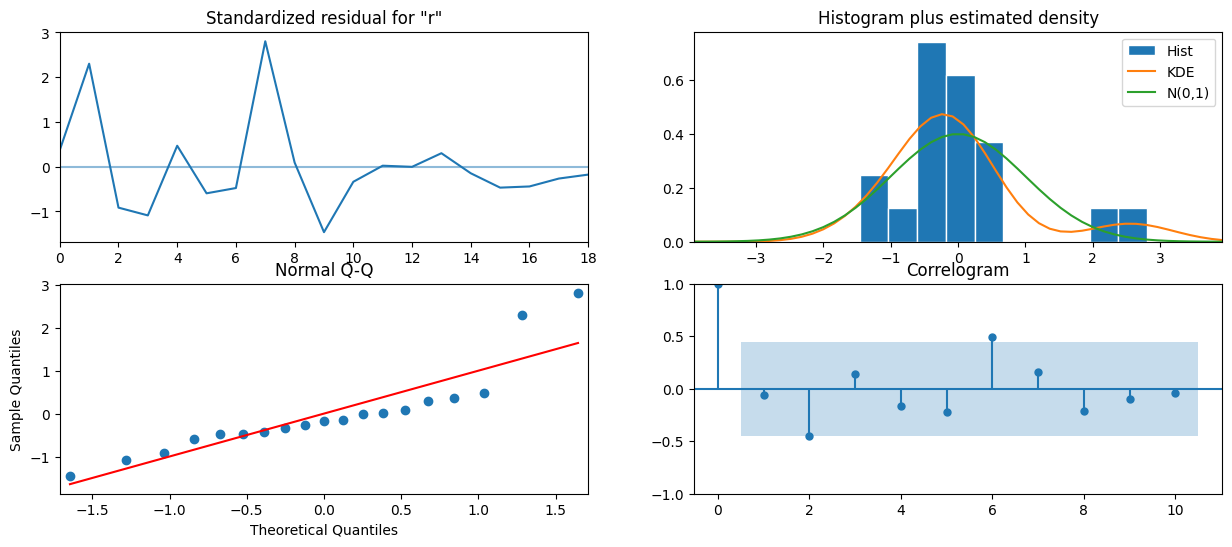

'\nprint("Ljung-Box Test Statistic:")\nprint(lb_test_stat)\nprint("\nP-values:")\nprint(lb_p_value)\n'

In [94]:
from statsmodels.stats.diagnostic import acorr_ljungbox
ts.summary()

ts.plot_diagnostics(figsize = (15, 6))
plt.show()

# Perform the Ljung-Box test
residuals = ts.resid
lj = acorr_ljungbox(residuals, lags=18)
lb_test_stat, lb_p_value = lj["lb_stat"], lj["lb_pvalue"]

# Print the test statistics and p-values
"""
print("Ljung-Box Test Statistic:")
print(lb_test_stat)
print("\nP-values:")
print(lb_p_value)
"""

In [17]:
# get train_start, train_end, test_end
# start or update, no need train_start, train_end, test_end
if future_predicting == True: # predict future with data until now, not backtest
    # train_start, train_end, test_end, train_size(y), test_size(m)
    train_start, train_end, test_end = t.traintest_period(None, None, None, train_size, test_size, "begin", future_predicting) 
else: # backtest
    # train_start = train_end - train_size; test_end = ~
    train_start, train_end, test_end = t.traintest_period(None, 
                                                          model_strategy["test_year"], 
                                                          None, 
                                                          train_size, test_size, "begin") 

print(train_start)
print(train_end)
print(test_end)

performance_rolling = pd.DataFrame()
rplsw_rolling = pd.DataFrame()
market_rolling = pd.DataFrame()
loss_rolling = []
longshort_thres = None

while True: # Update data    
    # train.py
    t = summary()
    print("===================================")
    gc.collect()
    fnl_df = t.Xy(data, train_start, train_end, test_end)   # fnl_df = (X_train, y_train, X_test, y_test)
    if fnl_df[2].shape[0] == 0:                             # check if test data == None
        print(fnl_df[2].shape)
        train_start, train_end, test_end = t.traintest_period(train_start, train_end, test_end, train_size, test_size, "update")
        continue
    pmd_mdl = pmd.auto_arima(train_data['日報酬率(%)'], stationary = True)
    pmd_mdl.summary()
    print(train_start, train_end, test_end)
    
    """
    print(min(fnl_df[0].reset_index()["ymd"]))
    print(max(fnl_df[0].reset_index()["ymd"]))
    """
    """
    true_predict, longshort_thres, loss = t.data_train(fnl_df, model_strategy, param, longshort_thres)
    performance, rplsw, market = t.compute_ret(data_tp=true_predict, not_short=True, print_detail=False)  
    performance_rolling = pd.concat([performance_rolling, performance], axis=0)
    rplsw_rolling = pd.concat([rplsw_rolling, rplsw], axis=0)
    market_rolling = pd.concat([market_rolling, market], axis=0)
    loss_rolling.append(loss)
    print(f"perform: {performance_rolling['performance'].mean()}")
    print(f"market: {market_rolling['return'].mean()}")
    """
    train_start, train_end, test_end = t.traintest_period(train_start, train_end, test_end, train_size, test_size, "update") 
    if test_end > max(data.reset_index()["ymd"]):
        break
    break
    

2018-01-01 00:00:00
2020-12-31 00:00:00
2021-01-31 00:00:00
2018-01-01 00:00:00 2020-12-31 00:00:00 2021-01-31 00:00:00


In [90]:
# nn: nn_{param['n_trials']}trials
# linear: linear
# ...
with open(
    f"result_train{model_strategy['train_size']}test{model_strategy['test_size']}/{model}.pickle", 
    "wb") as f:
    pickle.dump([performance_rolling, loss_rolling, rplsw_rolling], f)
"""
with open(f"result/nn_{param['n_trials']}.pickle", "rb") as f:
    a = pickle.load(f)
"""

'\nwith open(f"result/nn_{param[\'n_trials\']}.pickle", "rb") as f:\n    a = pickle.load(f)\n'

(performance                          0.01587
 ymd            2022-03-11 14:04:08.275862016
 dtype: object,
 performance                       0.051638
 ymd            259 days 00:54:18.434810200
 dtype: object,
 return                         0.008671
 ymd       2022-03-11 14:04:08.275862016
 dtype: object,
 return                       0.074491
 ymd       259 days 00:54:18.434810200
 dtype: object)

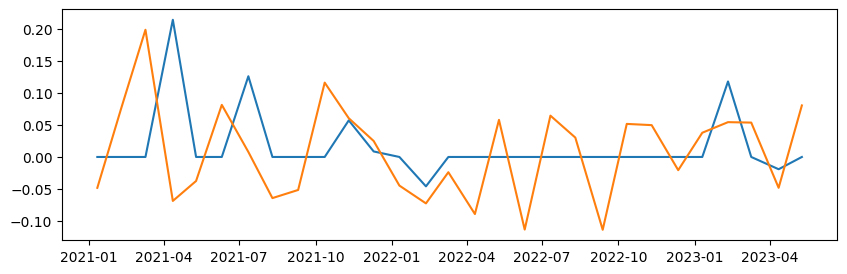

In [94]:
"""
# Here returns do not -0.004 so it should be 0.004 and higher than market one so that beat market
"""
plt.figure(figsize=(10, 3))
plt.plot(performance_rolling.set_index("ymd")["performance"])
plt.plot(market_rolling.set_index("ymd")["return"])
performance_rolling.mean(), performance_rolling.std(), market_rolling.mean(), market_rolling.std()

In [194]:
for i, k in zip(X_train.columns, linear_regression.coef_):
    if k>2 or k<-2:
        print(i, k)

市值(百萬元) -80.05638918050303
市值比重％ 68.70383201626508
單月營收成長率％ 17044871767719.094
單月營收與上月比％ 1895929827671.5144
淨值(千元) 3.646971913764108
流通在外股數(千股)_y 5.05927021421087
以合併為主單月營收成長率％ -17044871767718.996
以合併為主單月營收與上月比％ -1895929827671.476
外資總投資股數(千股) -56.577392578125
外資總投資市值(百萬) -53.65380859375
合計持股數(千股) 52.57489013671875
合計持股數市值(百萬) 65.20849609375
流通在外股數(千股) -3.6552734375
ADE減分 -839294939795.4333
總資產 5.8770751953125
常續性利益 3.6710205078125
CFO 3.83929443359375
營業利益 -6.0037841796875
股東權益 -6.2100830078125
